In [ ]:
import numpy as np
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

data = pd.read_csv('fcst_training/int_fcst_data_train.csv')
test = pd.read_csv('fcst_training/int_fcst_data_test.csv')
print(data.shape,test.shape)
data.head(5)

(31113, 3) (7084, 2)


id        date  sale
0   1  2016-06-06   114
1   1  2016-06-07    47
2   1  2016-06-08    26
3   1  2016-06-12    80
4   1  2016-06-13    36

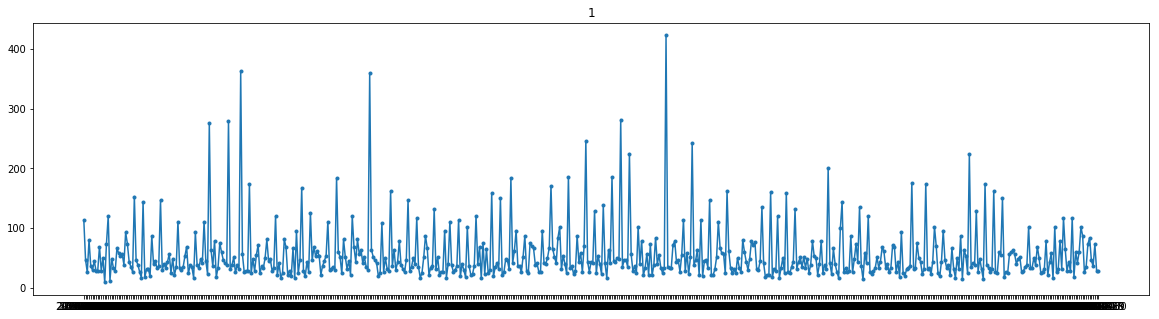

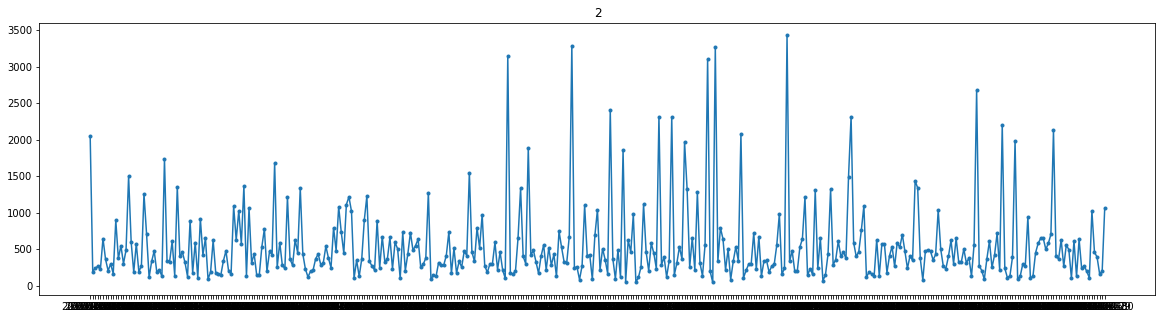

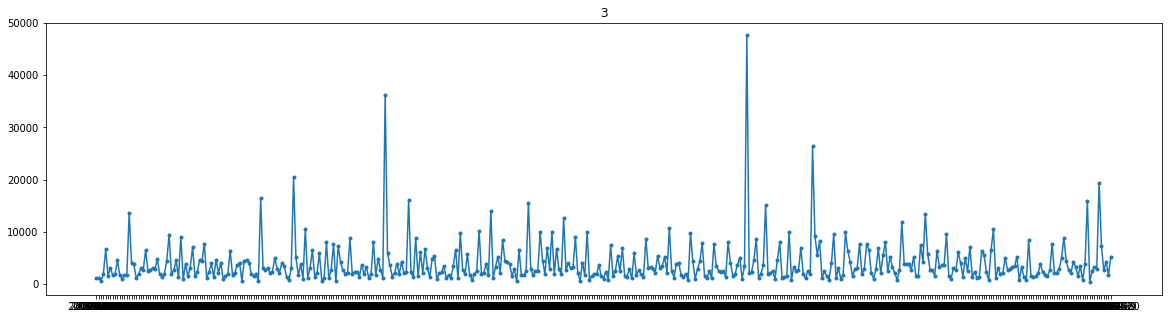

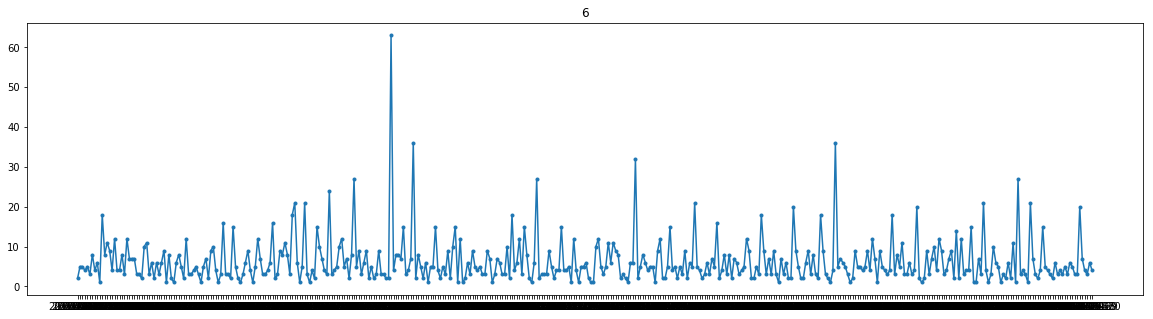

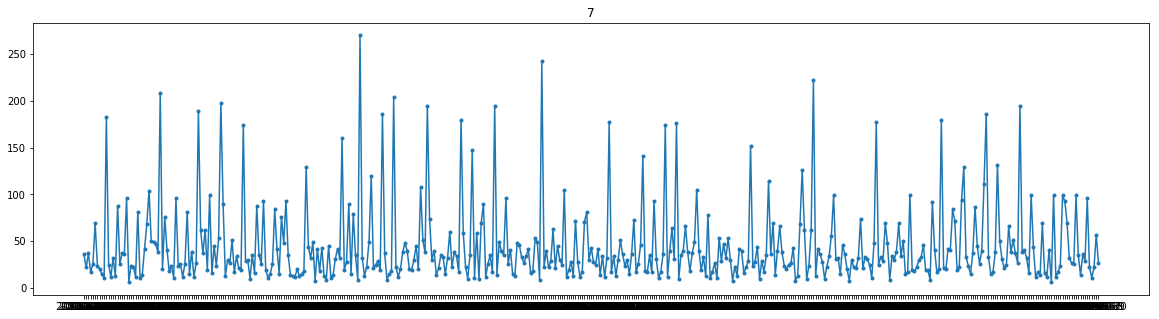

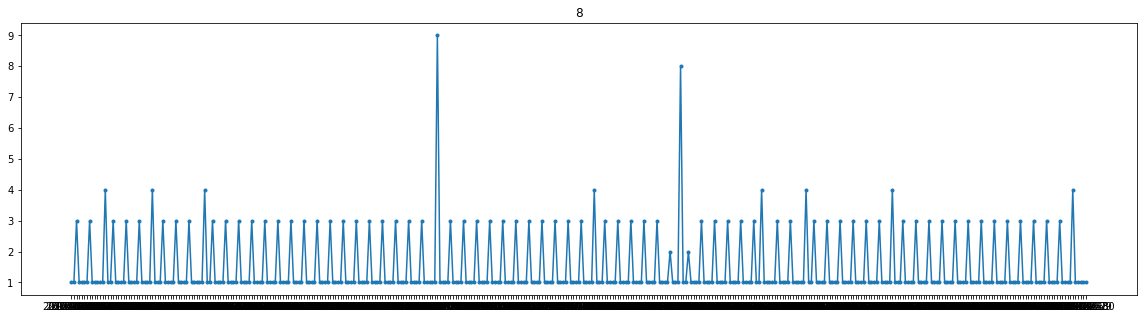

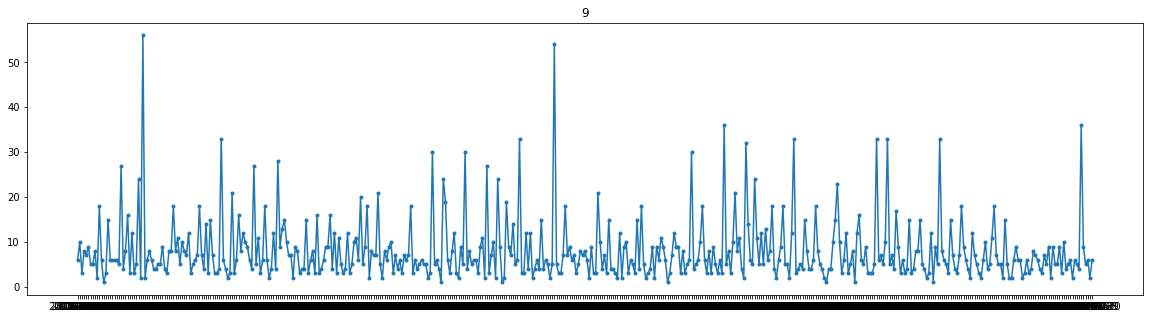

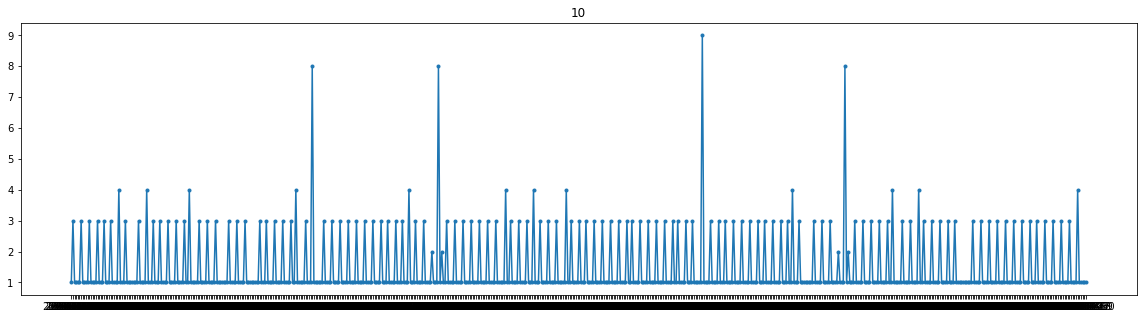

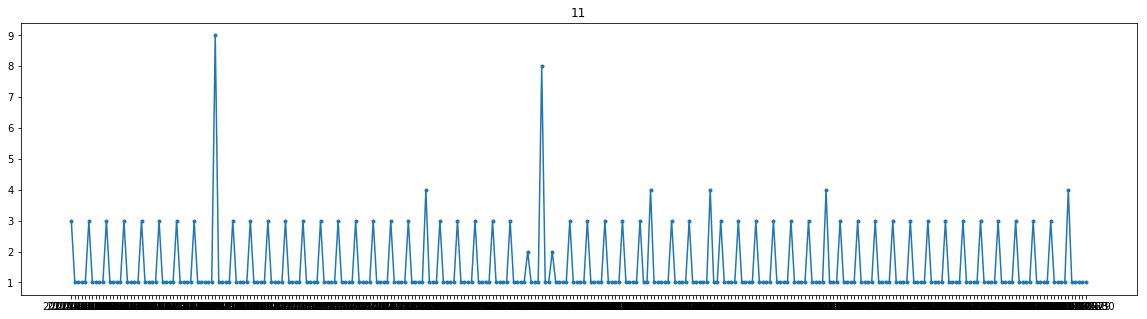

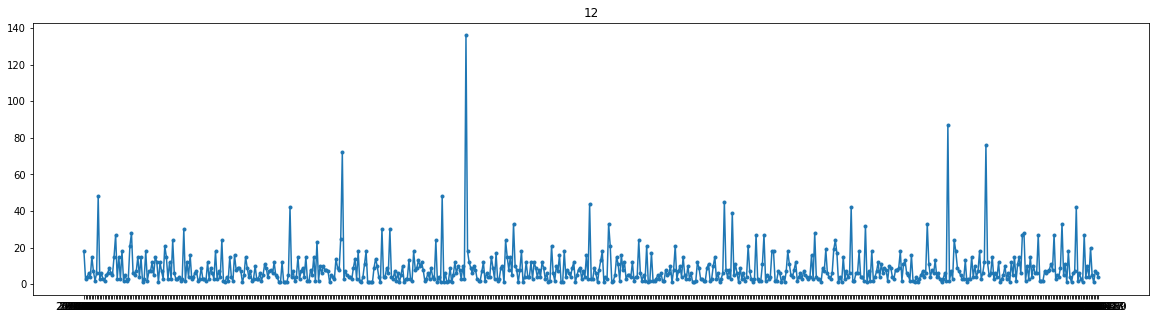

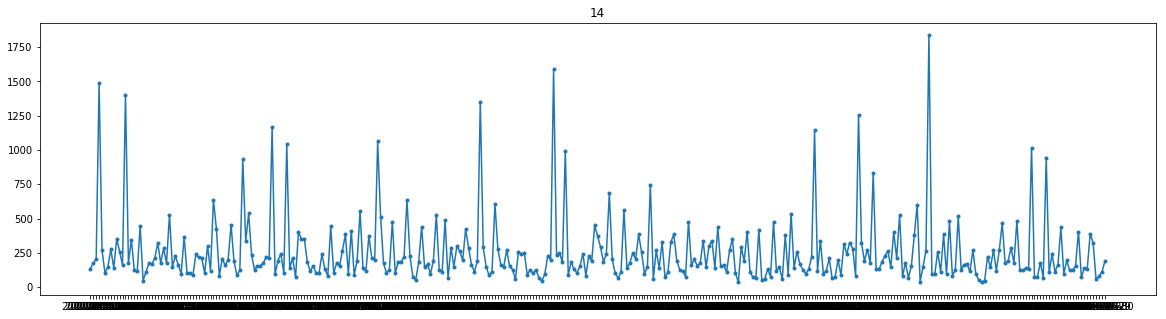

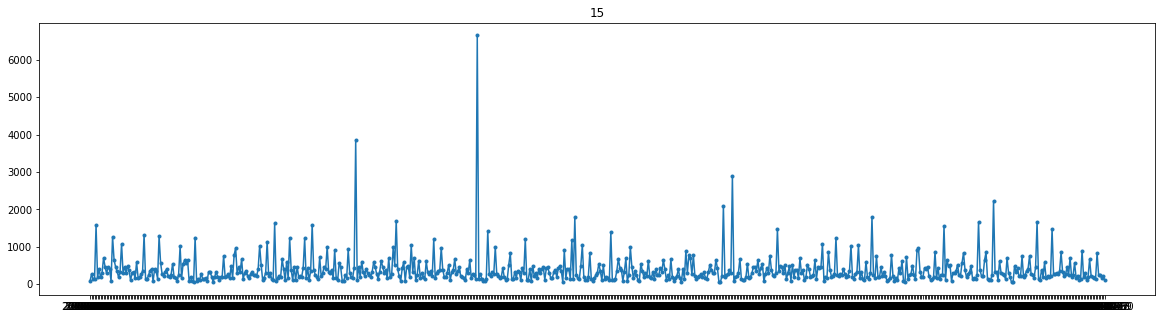

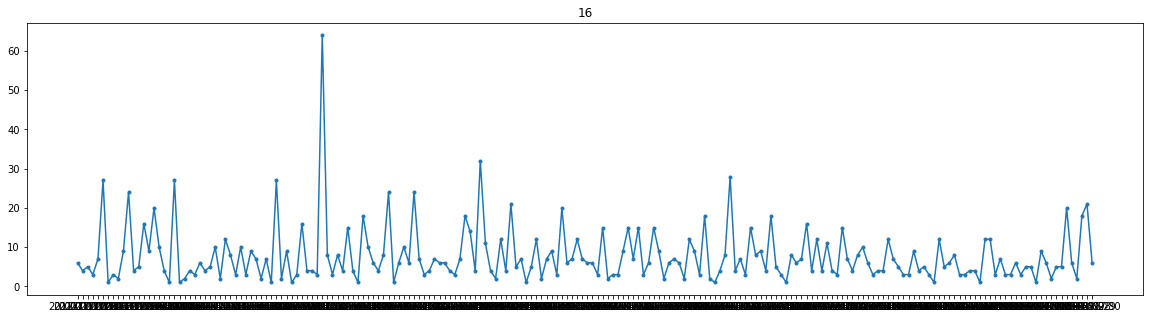

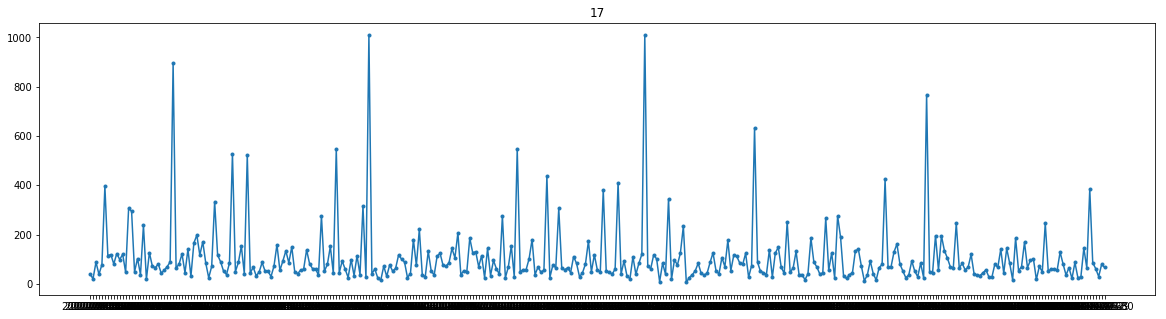

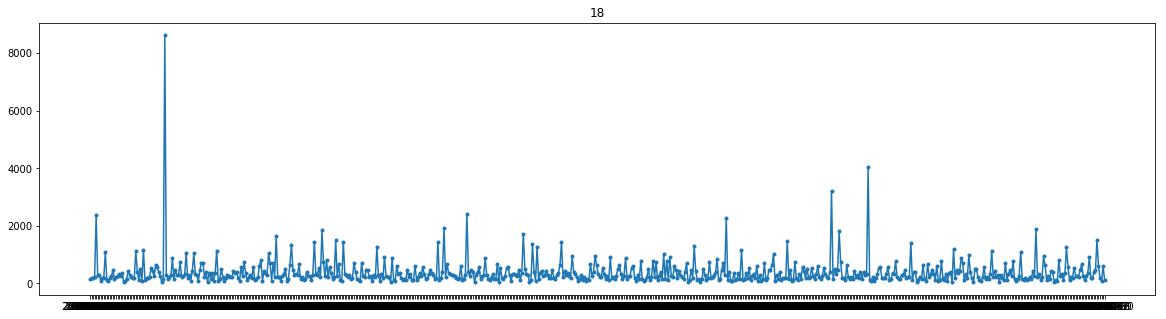

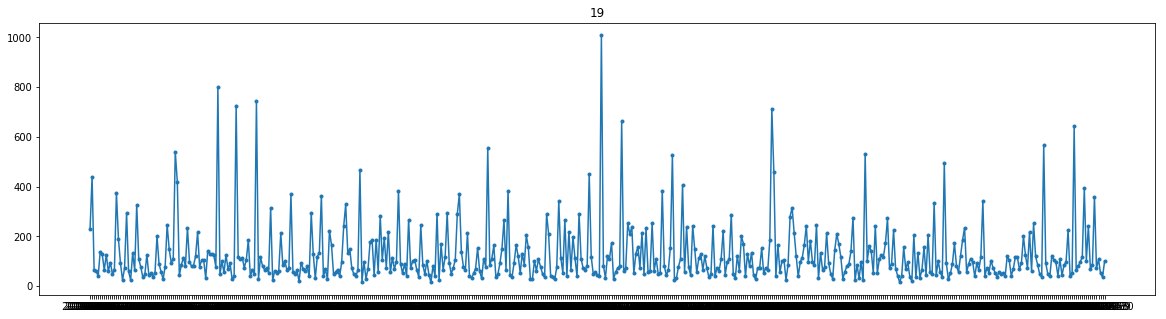

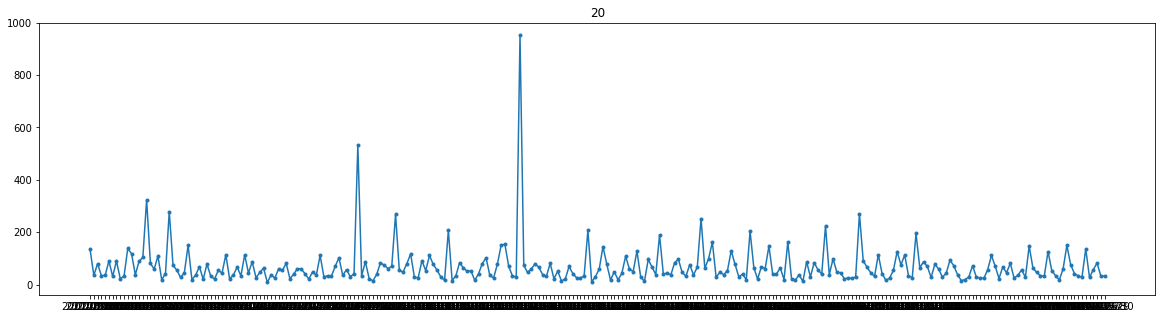

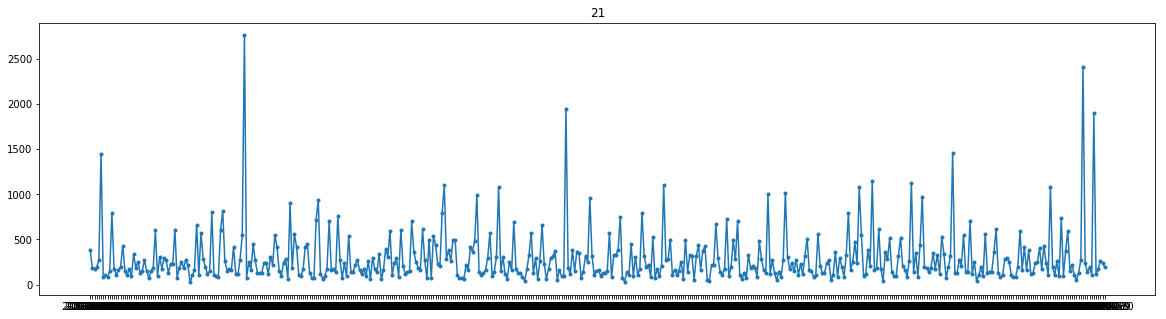

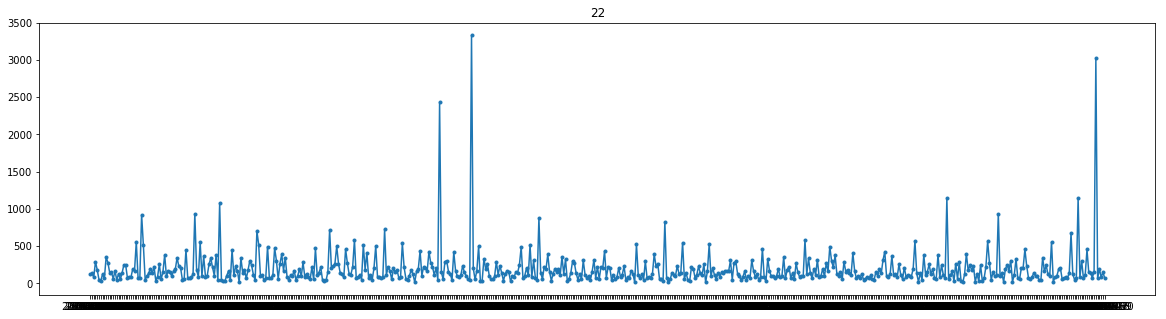

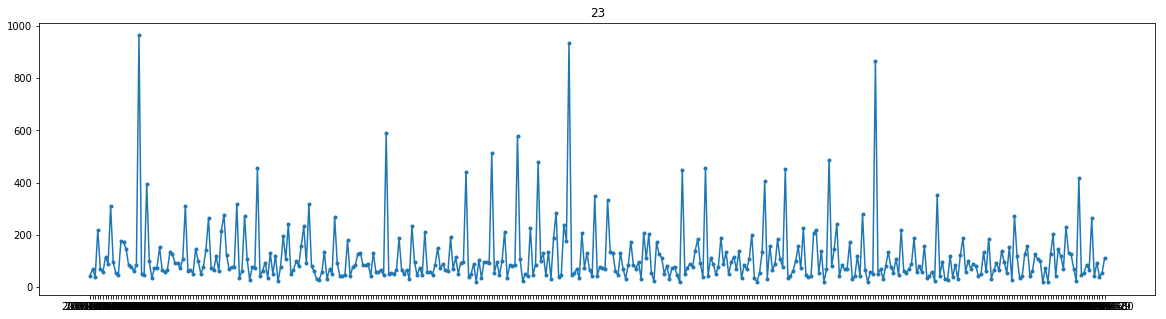

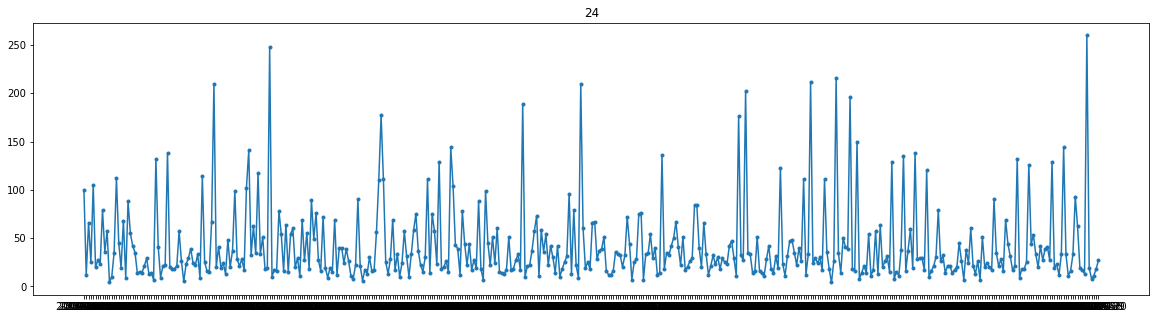

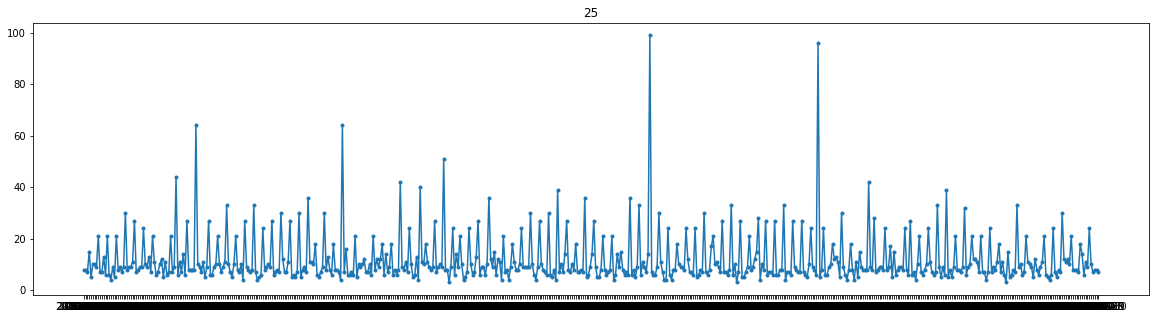

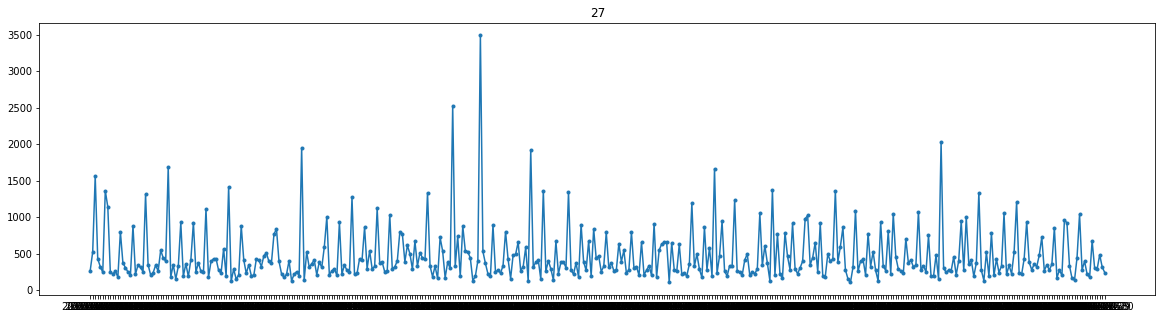

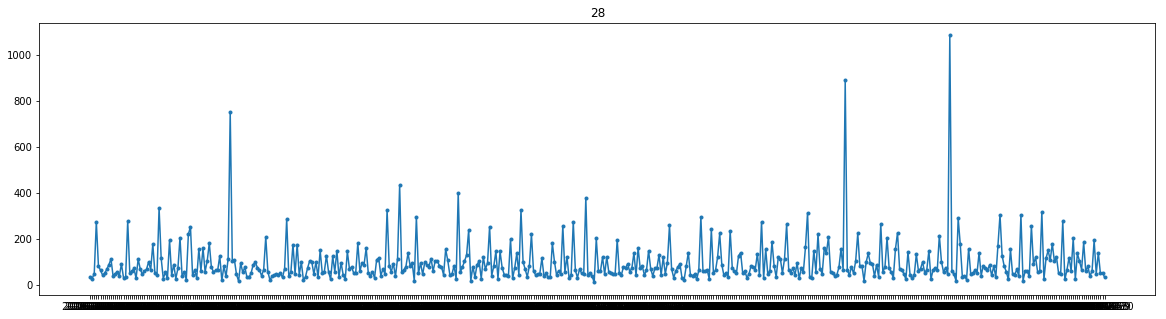

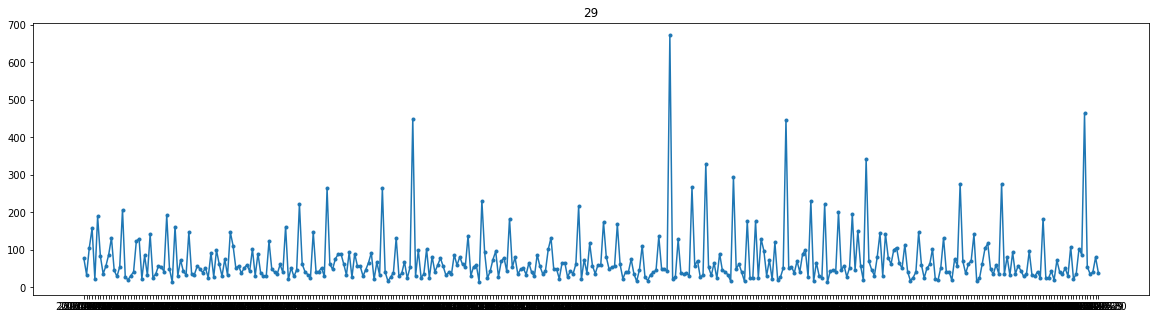

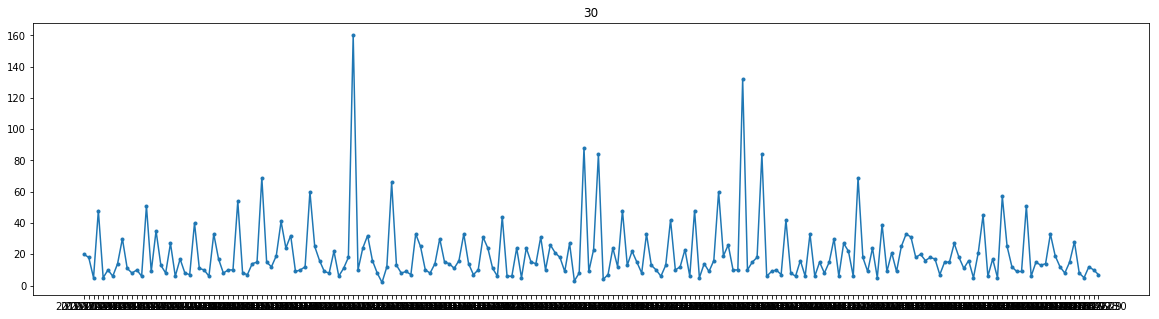

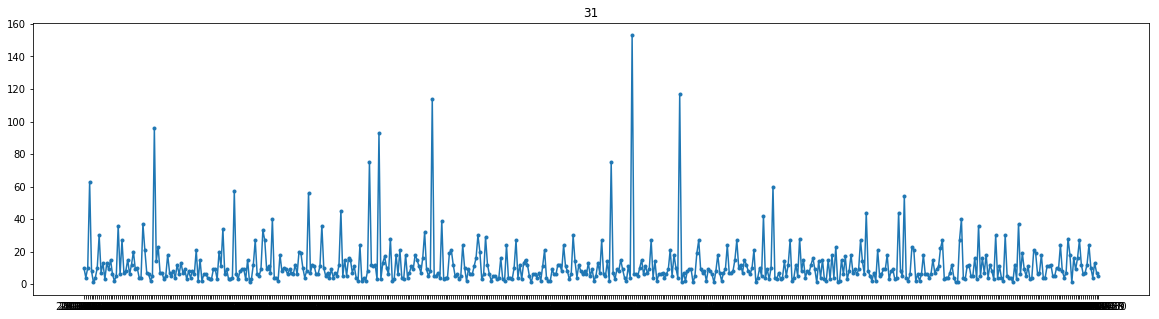

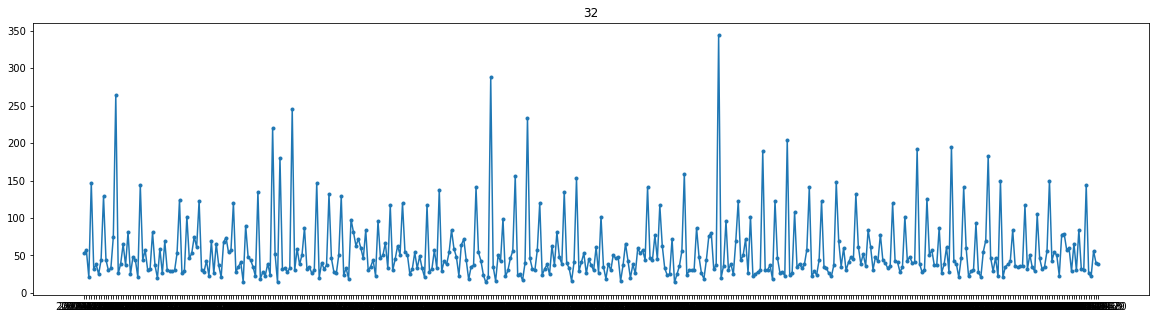

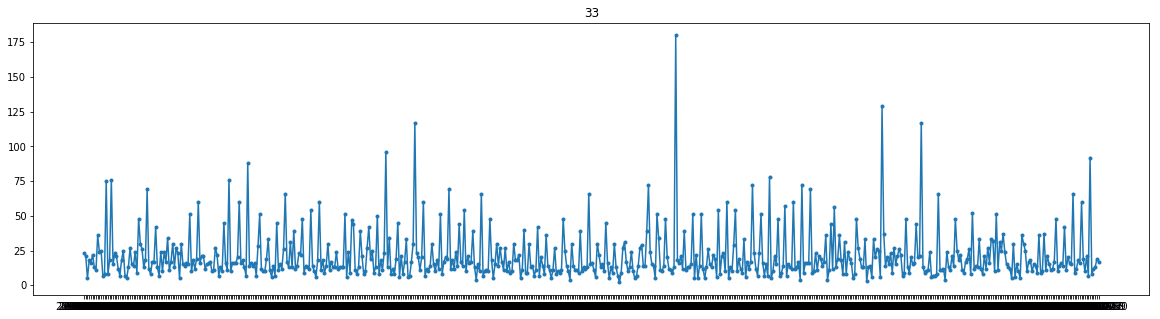

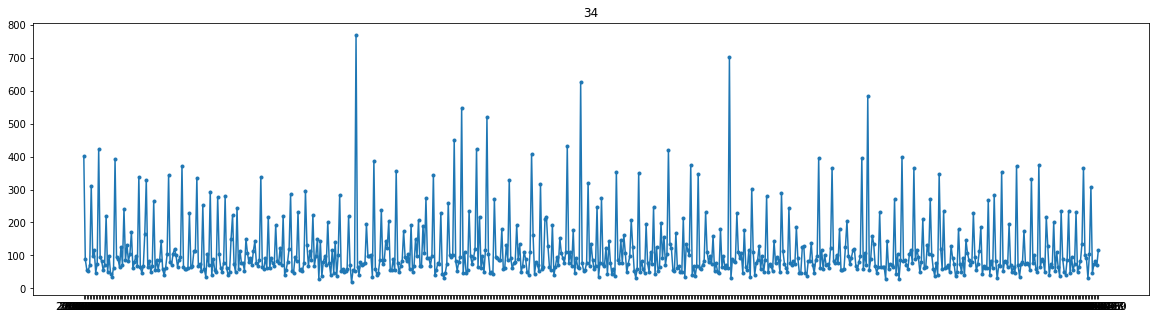

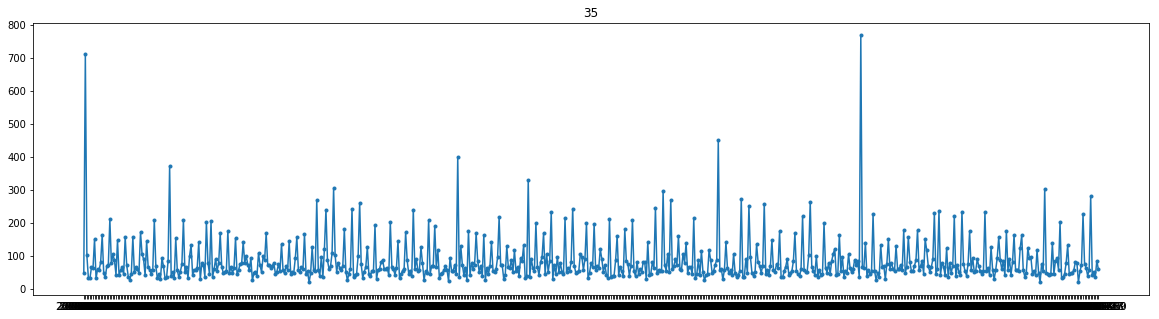

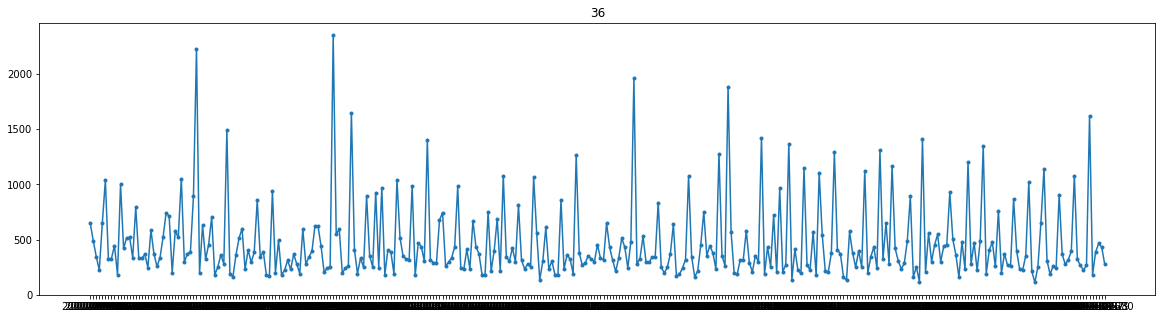

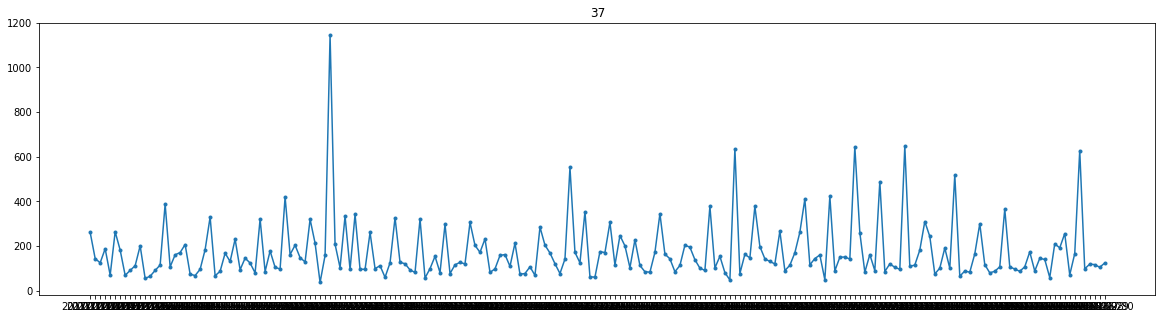

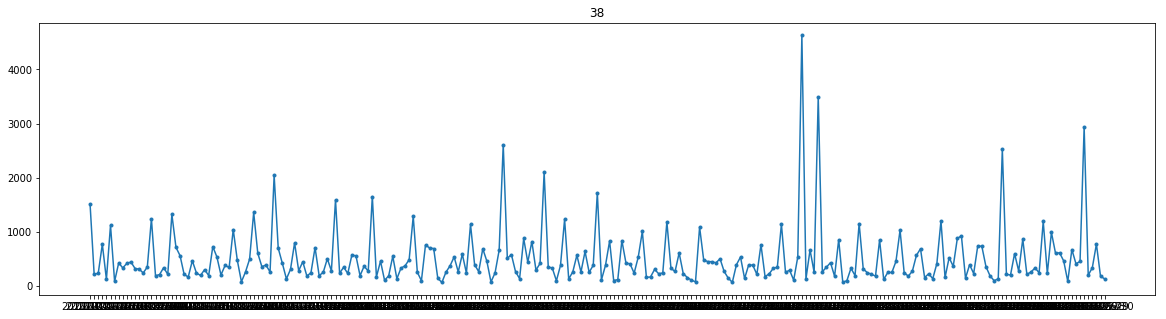

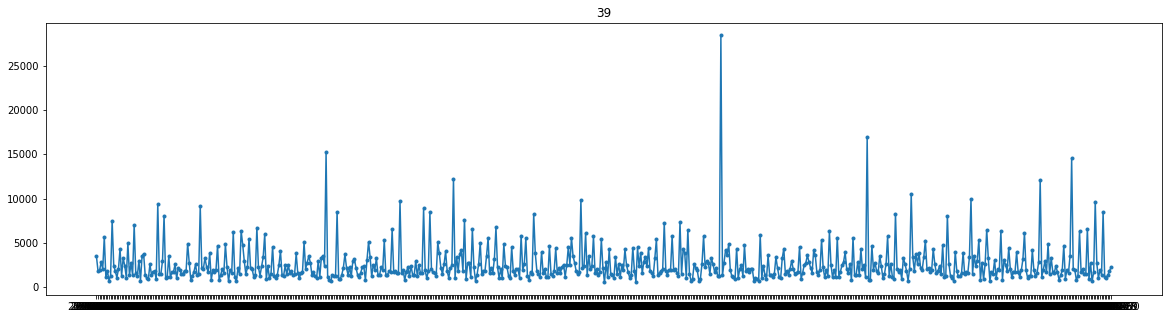

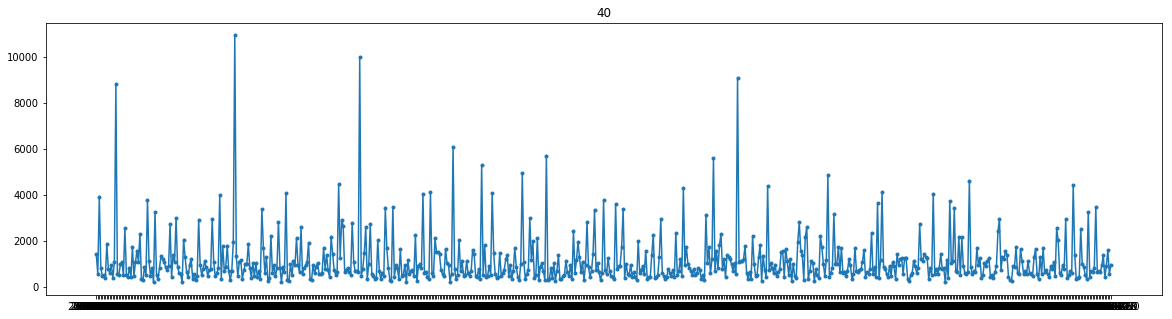

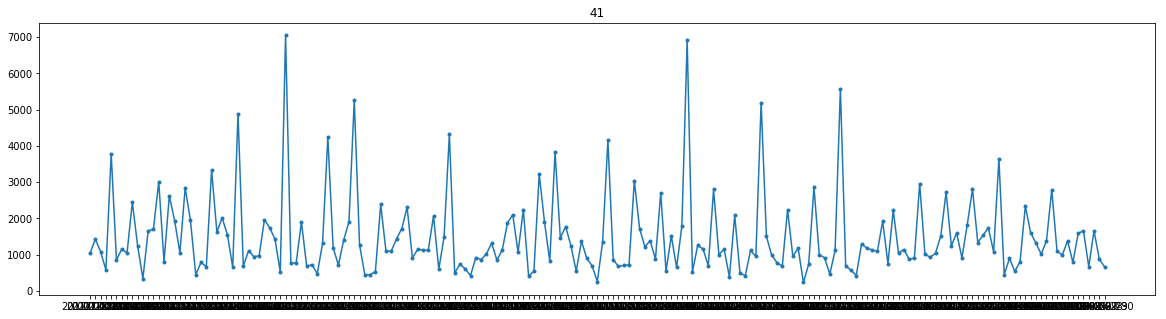

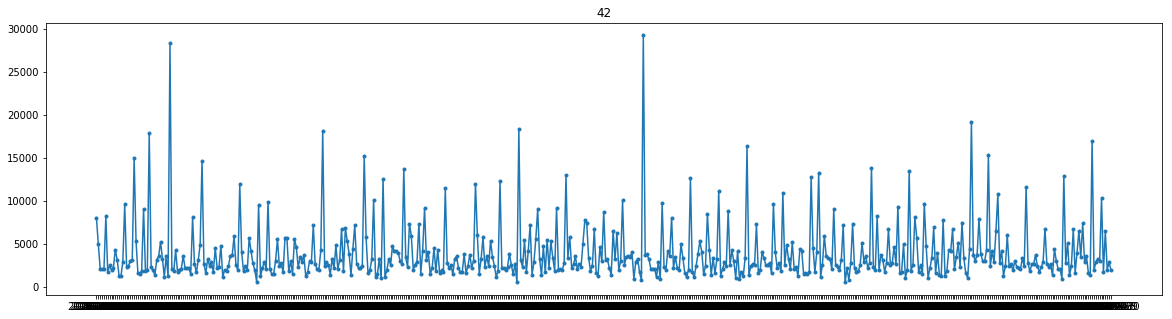

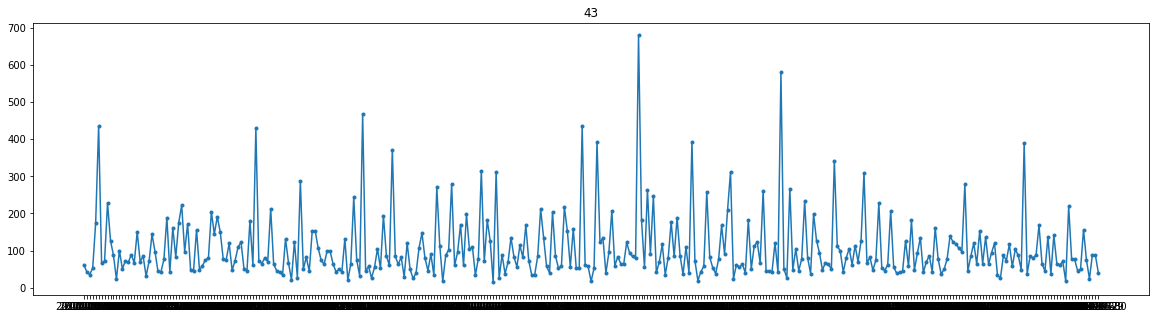

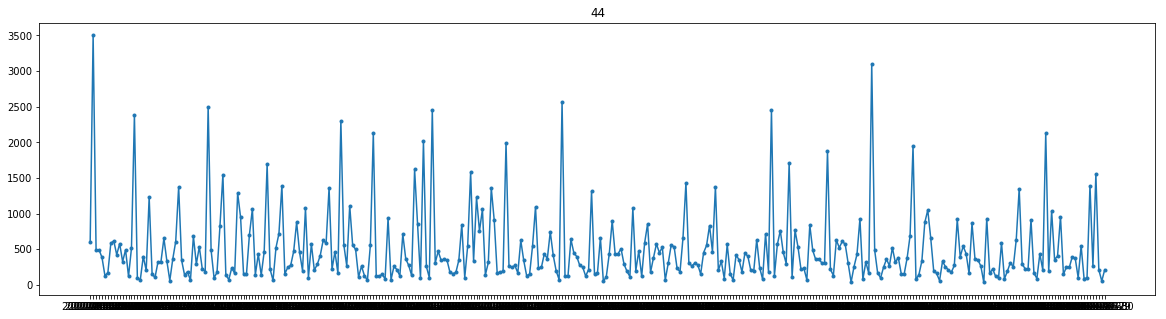

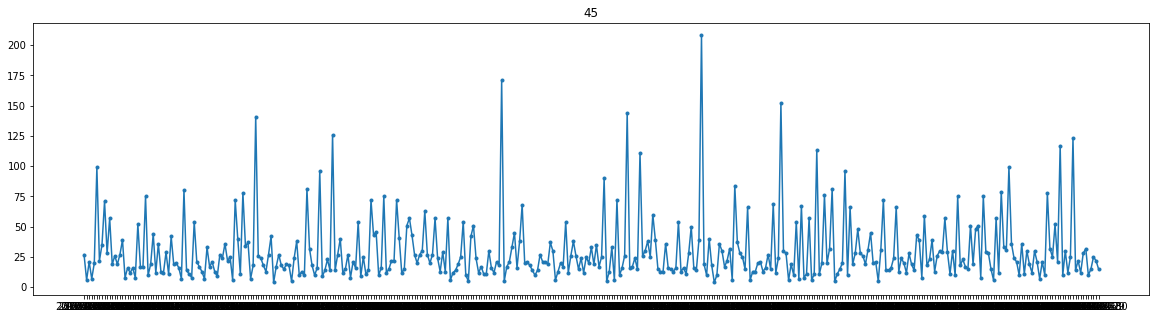

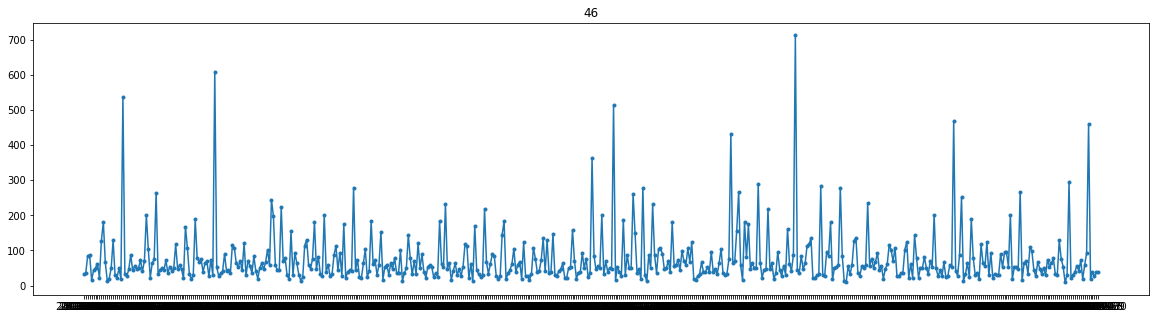

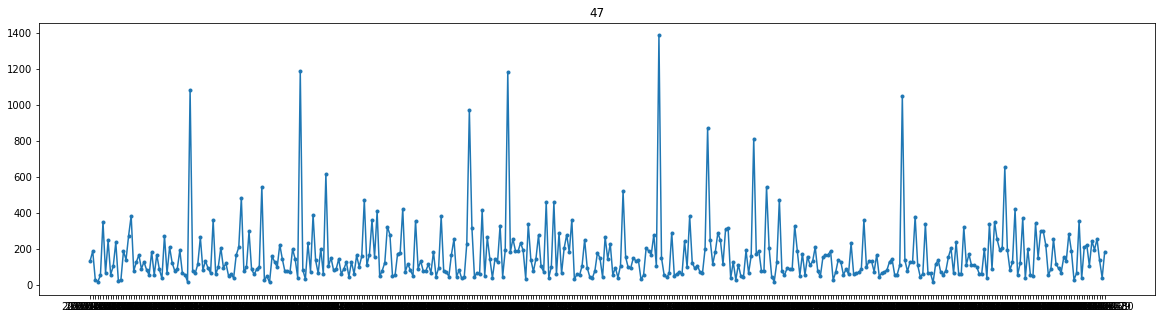

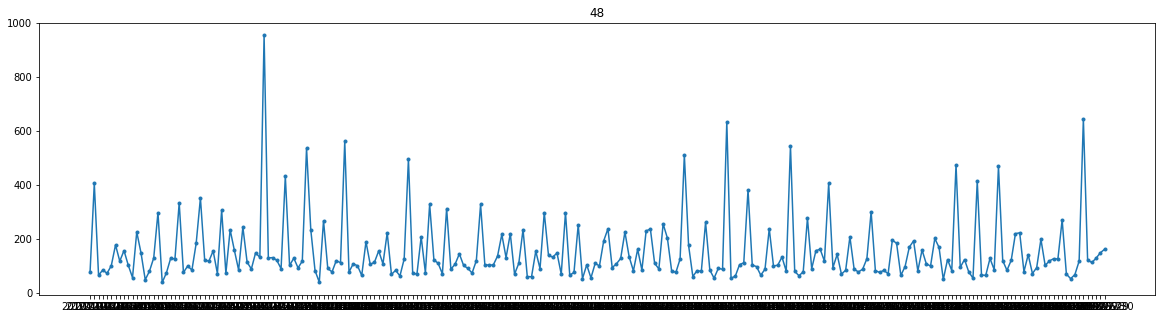

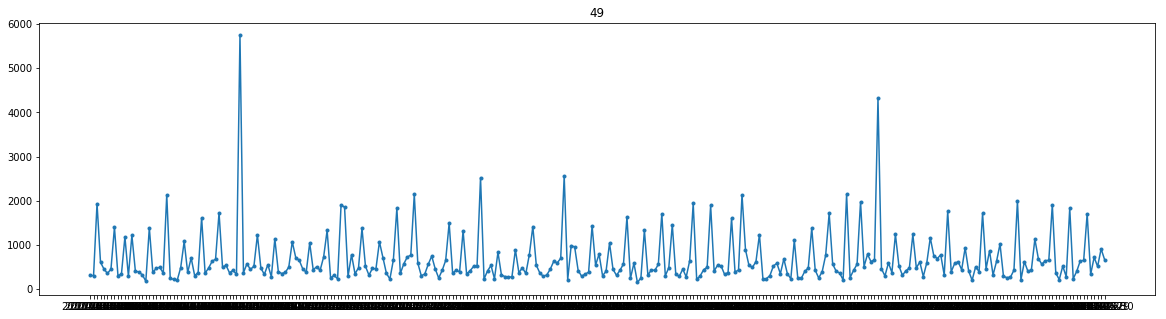

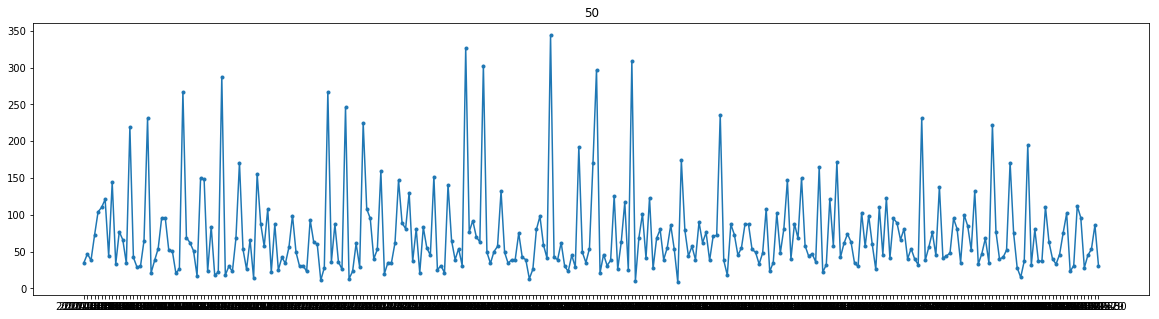

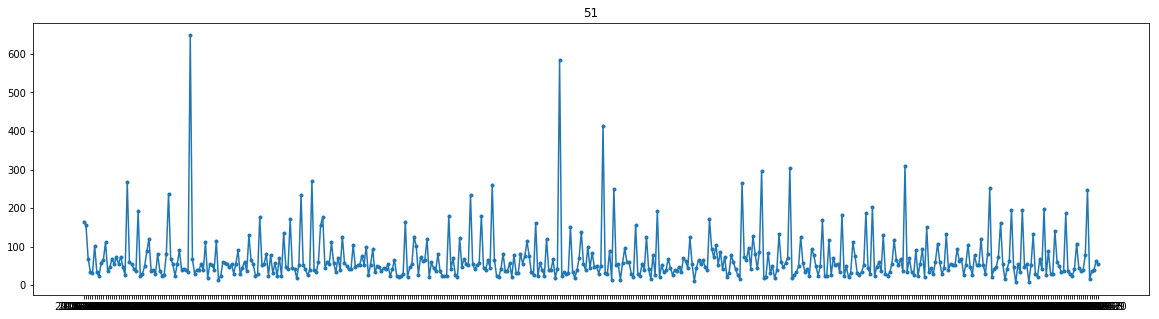

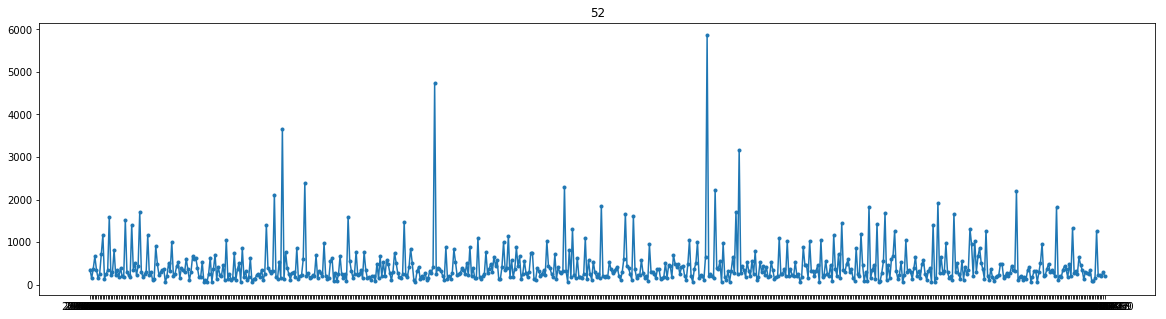

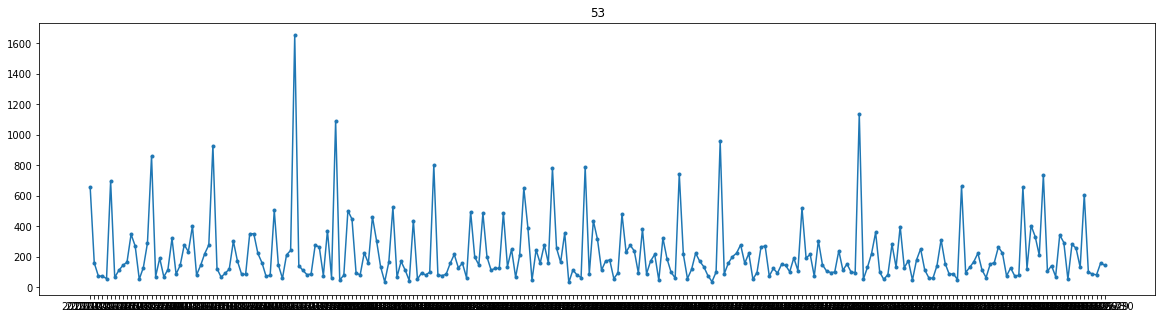

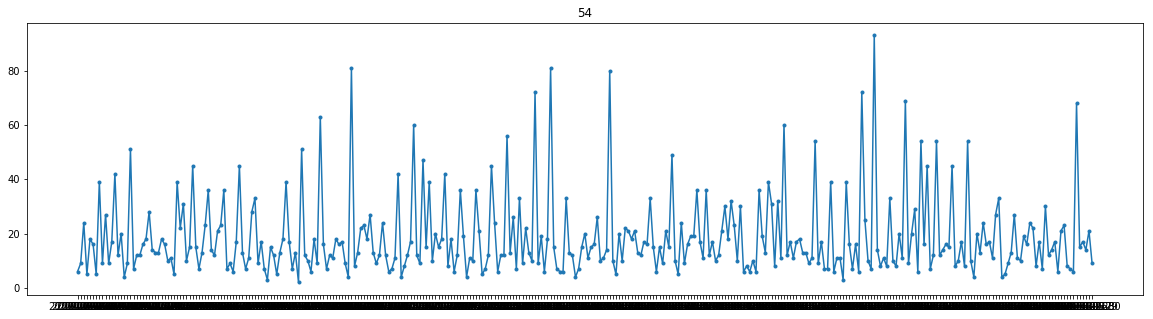

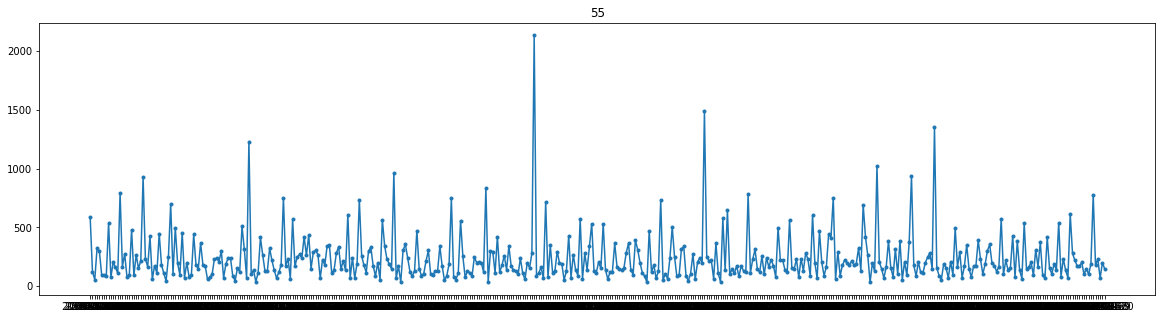

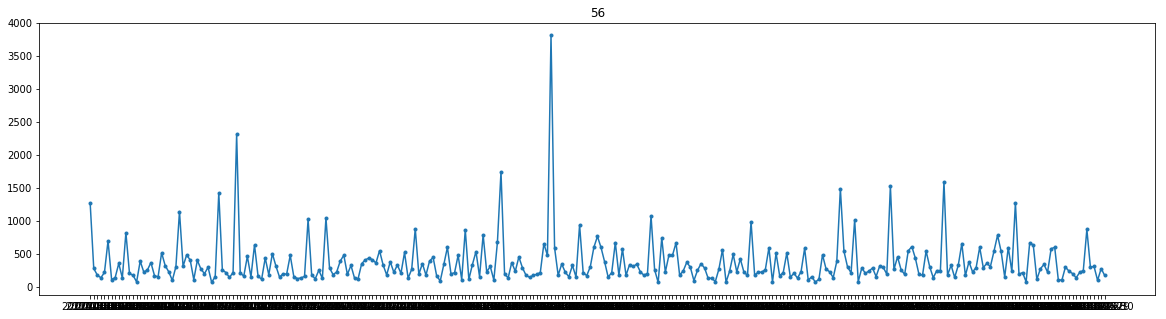

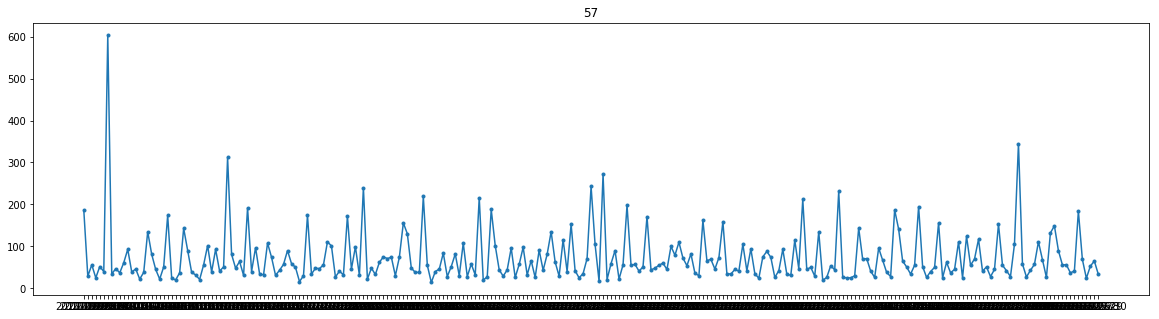

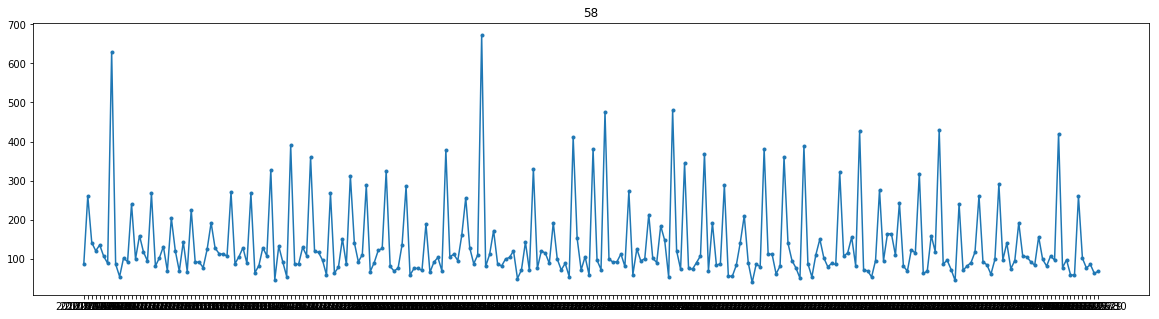

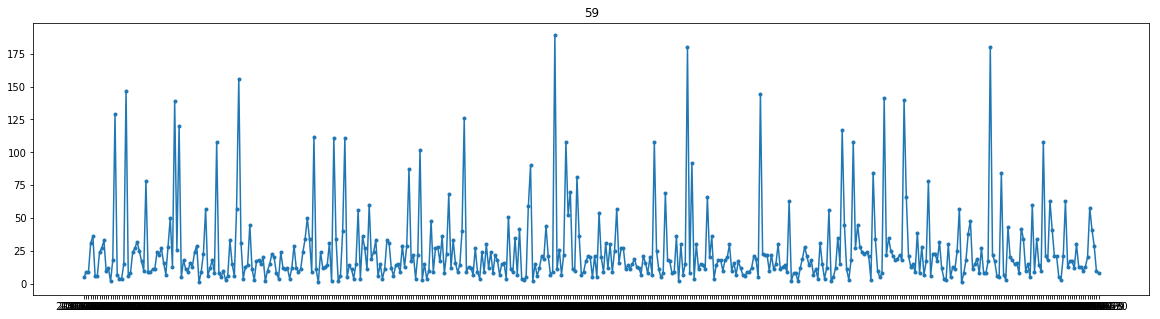

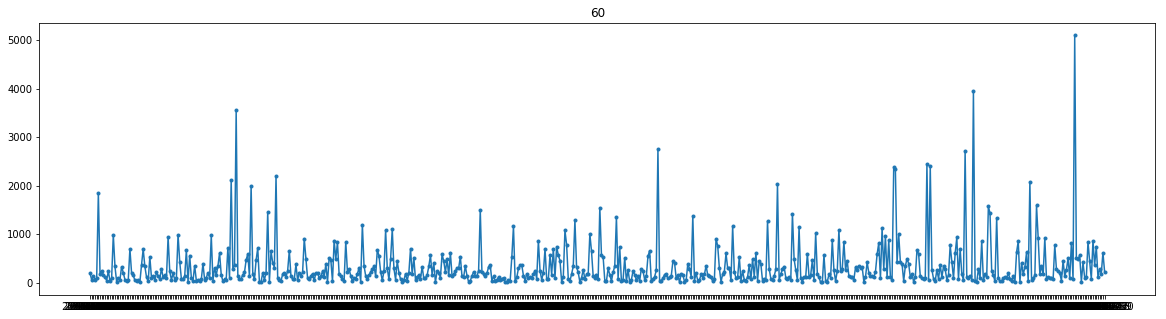

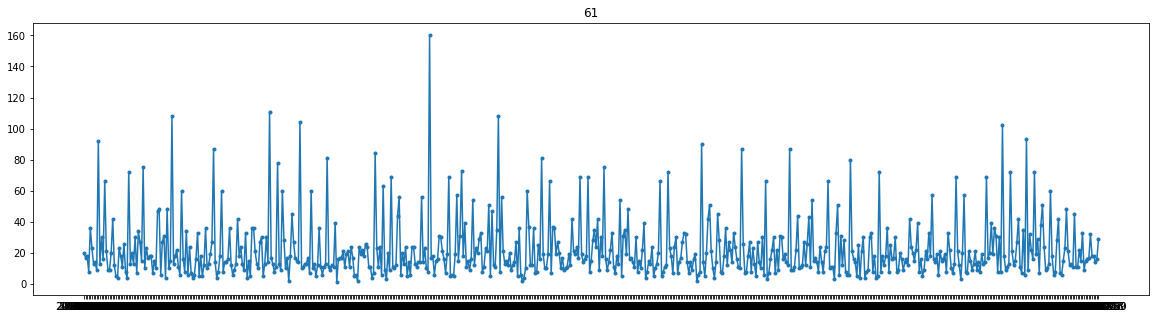

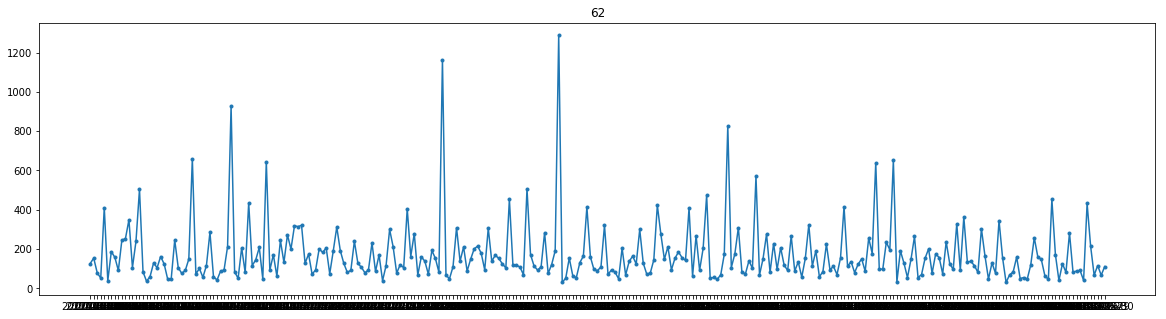

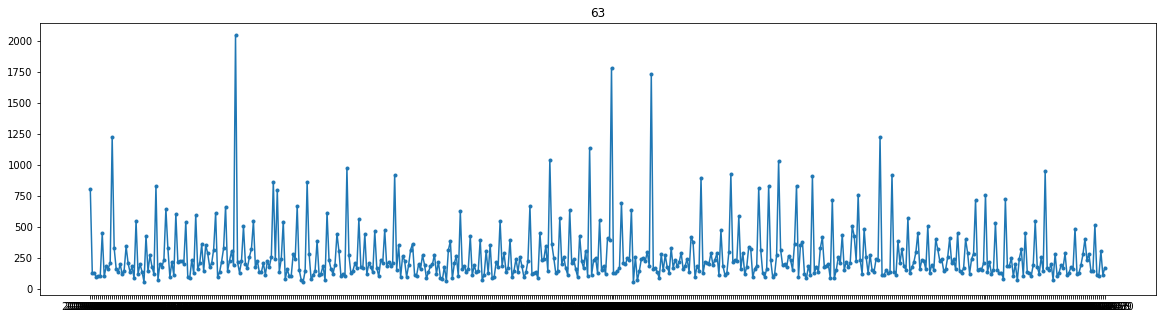

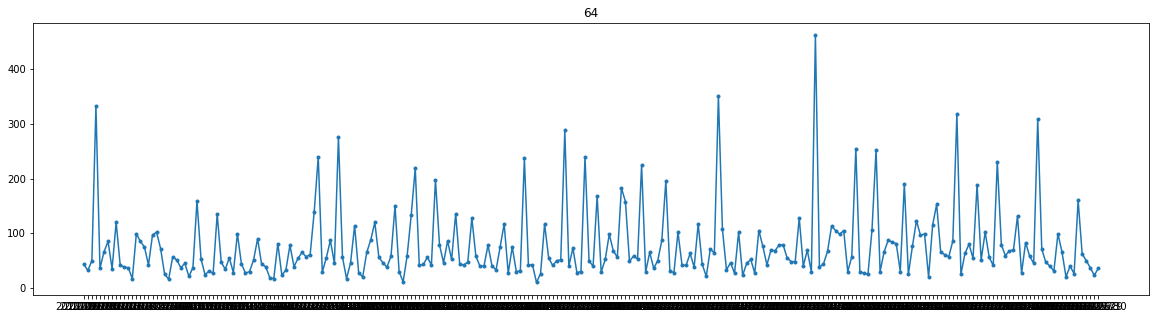

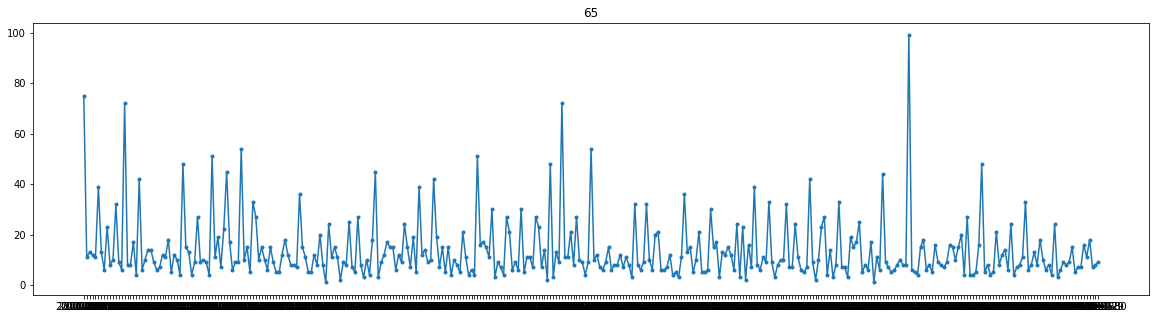

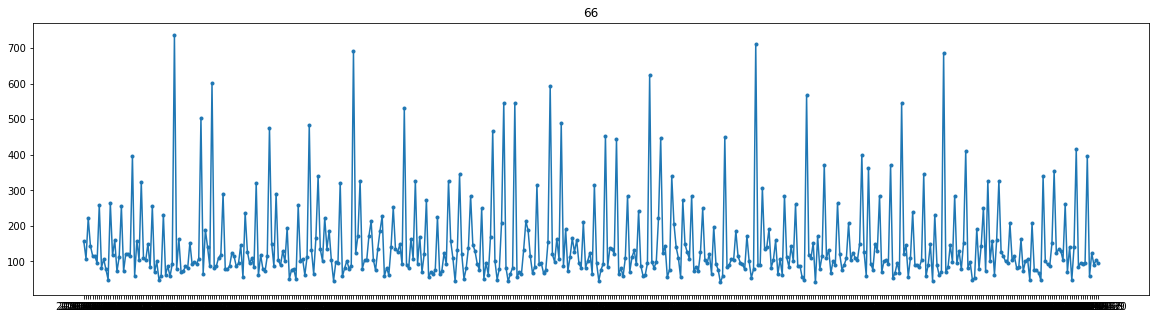

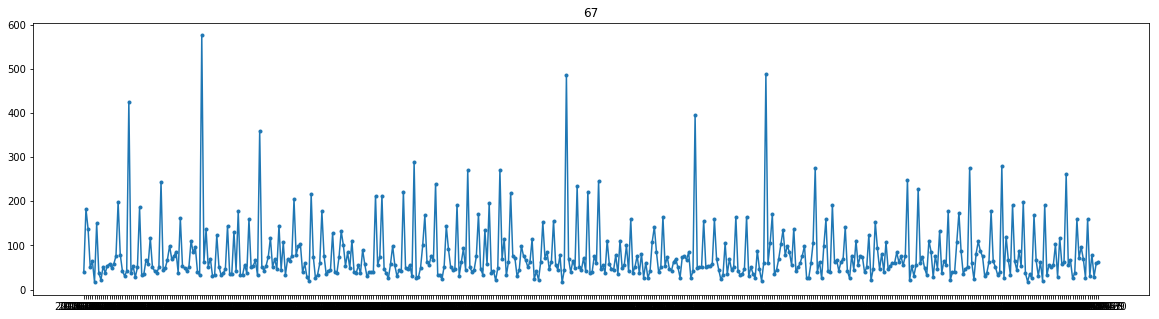

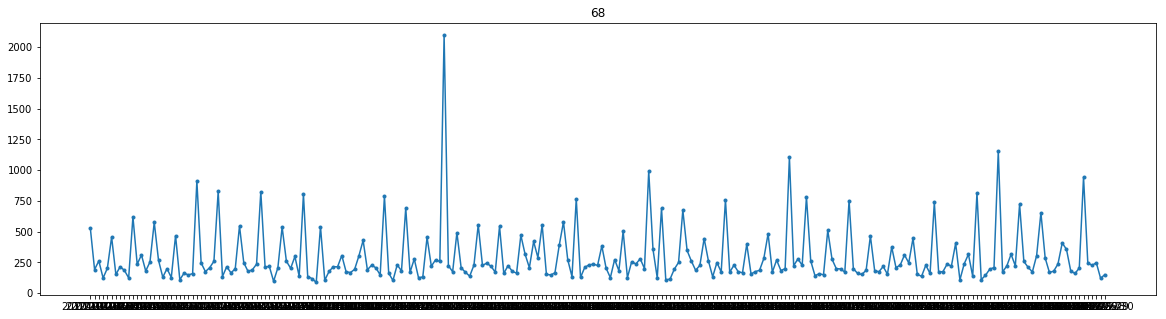

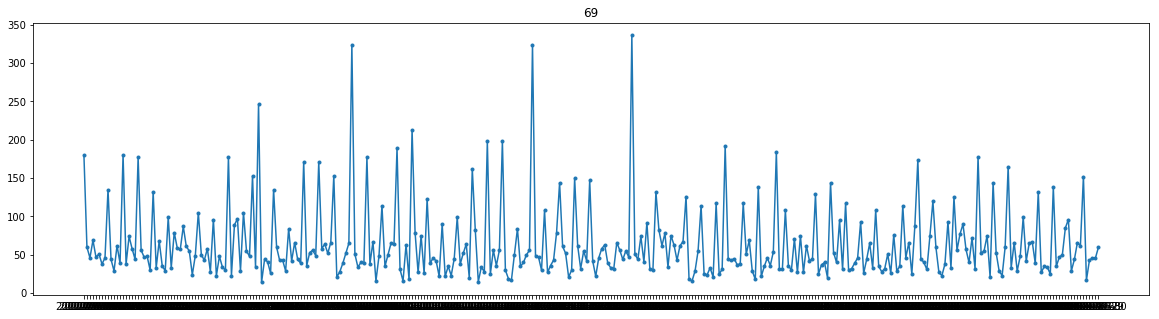

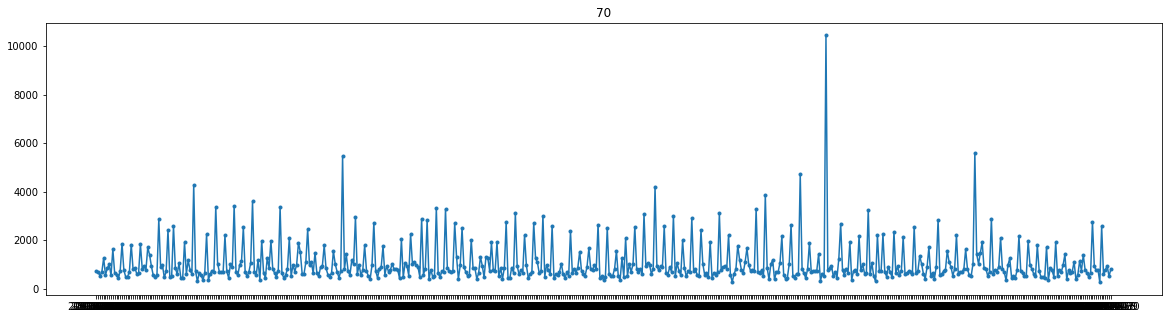

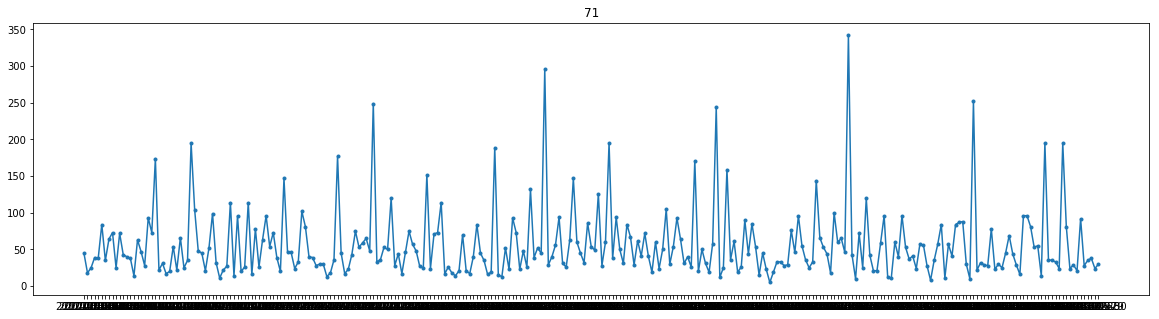

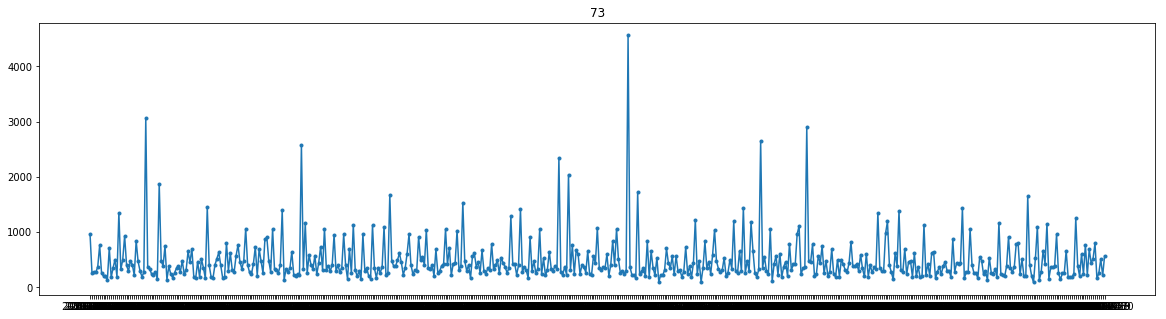

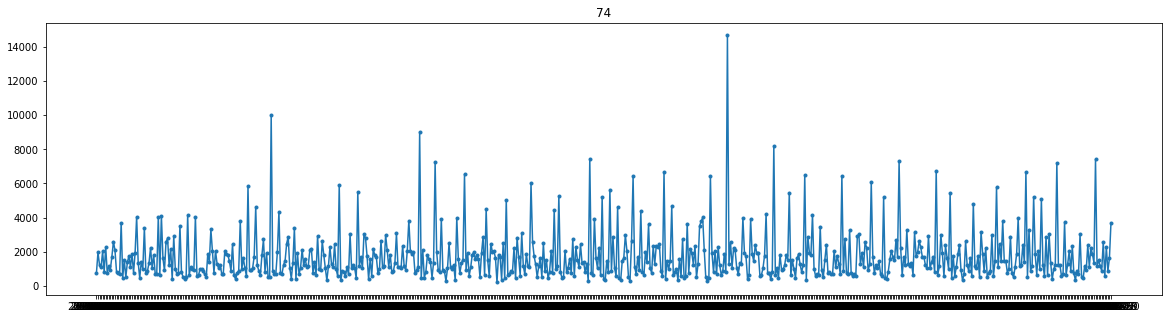

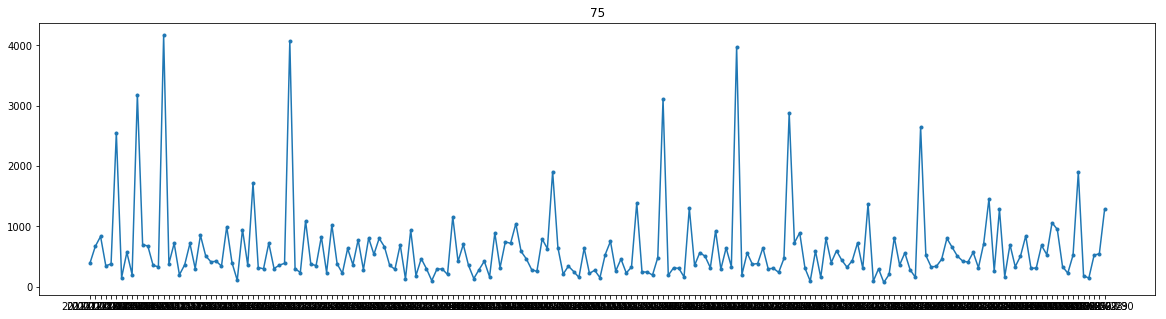

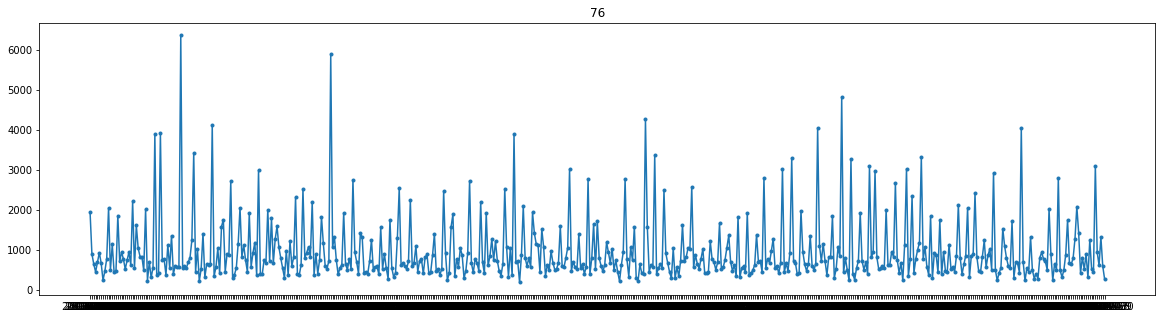

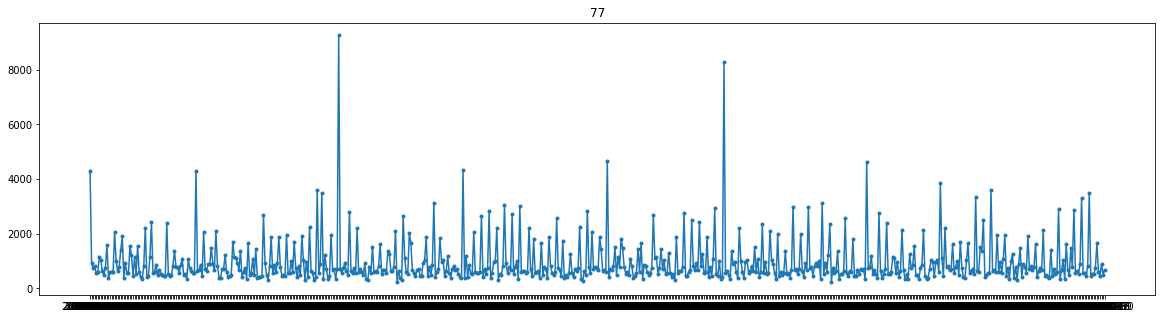

In [2]:
for i in sorted(data["id"].unique()):
    plt.figure(figsize=(20, 5))
    plt.plot(data[data["id"] == i]["date"],
                 data[data["id"] == i]["sale"],marker='.')
    plt.title(i)
    plt.show()
    plt.close()

In [3]:
min_date = np.min(data['date'])
max_date = np.max(data['date'])
data.set_index(['date', 'id'], inplace=True)
date_list = [x.strftime('%Y-%m-%d') for x in list(pd.date_range(start=min_date, end=max_date))]
data = data.unstack().reindex(date_list).fillna(0).stack().reset_index()
print(min_date,max_date)
data.head(5)

2016-01-11 2018-09-30


date  id  sale
0  2016-01-11   1   0.0
1  2016-01-11   2   0.0
2  2016-01-11   3   0.0
3  2016-01-11   6   0.0
4  2016-01-11   7   0.0

In [4]:
data_size = data.shape[0]
test_data = test.copy()
total = pd.concat([data,test_data],axis=0,sort=False)
total['start_time_delta'] = 0
total = total.reset_index()
total.head(5)

index        date  id  sale  start_time_delta
0      0  2016-01-11   1   0.0                 0
1      1  2016-01-11   2   0.0                 0
2      2  2016-01-11   3   0.0                 0
3      3  2016-01-11   6   0.0                 0
4      4  2016-01-11   7   0.0                 0

In [5]:
def add_start_time_delta(group):
    start_date = np.min(group.loc[group.sale!=0].date)
    group['start_time_delta'] = (pd.to_datetime(group['date'],format='%Y-%m-%d') - pd.to_datetime(start_date)).map(lambda x:x.days)
    group['start_year']= pd.to_datetime(start_date).year
    return group 
total = total.groupby('id').apply(add_start_time_delta)
del total['index']
total.head(5)

date  id  sale  start_time_delta  start_year
0  2016-01-11   1   0.0              -147        2016
1  2016-01-11   2   0.0              -420        2017
2  2016-01-11   3   0.0              -365        2017
3  2016-01-11   6   0.0              -392        2017
4  2016-01-11   7   0.0              -336        2016

In [6]:
total['date'] = pd.to_datetime(total['date'],format='%Y-%m-%d')
total['time_delta'] = (total['date'] - pd.to_datetime(min_date)).map(lambda x:x.days)
total['Year'] = total['date'].map(lambda x: x.year)
total['month'] = total['date'].map(lambda x:x.month)
total['day'] = total['date'].map(lambda x:x.day)
total['day_of_week'] = total['date'].dt.dayofweek
total['day_of_year'] = total['date'].dt.dayofyear
total['week_of_year'] = total['date'].dt.weekofyear
total['to_month_end'] = total['date'].dt.days_in_month - total['date'].dt.day
total['weekend'] = 0
rows = [i for i in range(total.shape[0]) if total.iloc[i]['day_of_week'] == 5 or total.iloc[i]['day_of_week']==6]
total.loc[rows,'weekend'] = 1
rows = [i for i in range(total.shape[0]) if total.iloc[i]['month']==10 and (total.iloc[i]['day']<=7 and 
                                                                            total.iloc[i]['day']>0)]
total['holiday_10'] = 0
total.loc[rows,'holiday_10'] = 1
rows = [i for i in range(total.shape[0]) if total.iloc[i]['month']==2 and (total.iloc[i]['day']<=21 and 
                                                                            total.iloc[i]['to_month_end']>=15)]
total['holiday_2'] = 0
total.loc[rows,'holiday_2'] = 1
data = total.iloc[:data_size]
data = data.loc[data['start_time_delta']>=0]
data = data.sort_values(by=["id",'date'] , ascending=[True,True]).reset_index()
del data['index']
test_data = total.iloc[data_size:]
test_data = test_data.loc[:,test_data.columns!='sale']
print(data.shape,test_data.shape)
data.head(10)

(45282, 16) (7084, 15)


date  id   sale  start_time_delta  start_year  time_delta  Year  \
0 2016-06-06   1  114.0                 0        2016         147  2016   
1 2016-06-07   1   47.0                 1        2016         148  2016   
2 2016-06-08   1   26.0                 2        2016         149  2016   
3 2016-06-09   1    0.0                 3        2016         150  2016   
4 2016-06-10   1    0.0                 4        2016         151  2016   
5 2016-06-11   1    0.0                 5        2016         152  2016   
6 2016-06-12   1   80.0                 6        2016         153  2016   
7 2016-06-13   1   36.0                 7        2016         154  2016   
8 2016-06-14   1   30.0                 8        2016         155  2016   
9 2016-06-15   1   45.0                 9        2016         156  2016   

   month  day  day_of_week  day_of_year  week_of_year  to_month_end  weekend  \
0      6    6            0          158            23            24        0   
1      6    7            1          159            23            23        0   
2      6    8            2          160            23            22        0   
3      6    9            3          161            23            21        0   
4      6   10            4          162            23            20        0   
5      6   11            5          163            23            19        1   
6      6   12            6          164            23            18        1   
7      6   13            0          165            24            17        0   
8      6   14            1          166            24            16        0   
9      6   15            2          167            24            15        0   

   holiday_10  holiday_2  
0           0          0  
1           0          0  
2           0          0  
3           0          0  
4           0          0  
5           0          0  
6           0          0  
7           0          0  
8           0          0  
9           0          0

In [7]:
data_package = []
test_package = []
for i in range(1,78):
    rows1 = [j for j in range(data.shape[0]) if data.iloc[j]['id']==i]
    rows2 = [j for j in range(test_data.shape[0]) if test_data.iloc[j]['id']==i]
    data_package.append(data.iloc[rows1])
    test_package.append(test_data.iloc[rows2])
print('complete')

complete


In [19]:
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge


def split_data(data,training_size=0.7):
    return data[:int(training_size*len(data))], data[int(training_size*len(data)):]

def create_train_data(data):
    label = np.zeros((data.shape[0]-7,1))
    sale = np.zeros((data.shape[0]-7,7))
    for i in range(label.shape[0]):
        label[i] = data.iloc[i+7]['sale']
        sale[i] = data.iloc[i:i+7]['sale'].T
    del data['id']
    del data['date']
    data_use = np.array(data)
    res = np.zeros((label.shape[0],data.shape[1]+7))
    res[:,:-7] = data_use[7:]
    res[:,-7:] = sale
    return res,label

def create_val_data(data,train):
    del data['id']
    del data['date']
    res = np.zeros((data.shape[0],data.shape[1]+7))
    label = np.zeros((data.shape[0],1))
    for i in range(label.shape[0]):
        label[i] = data.iloc[i]['sale']
        if i < 7:
            res[i,:-7] = np.array(data.iloc[i])
            if i == 0:
                res[i,-7:] = np.array(train.iloc[(-7+i):]['sale']).T
            else:
                res[i,-7:-i] = np.array(train.iloc[(-7+i):]['sale']).T
                res[i,-i:] = np.array(data.iloc[:i]['sale']).T
        else:
            res[i,:-7] = np.array(data.iloc[i])
            res[i,-7:] = np.array(data.iloc[i-7:i]['sale']).T
    return res,label

In [27]:
with PdfPages('multipage_pdf.pdf') as pdf:
    for i in range(77):
        print('for id',i)
        data_use = data_package[i]
        if data_use.shape[0] == 0:
            print('no id', i)
            continue
        train_data,val_data = split_data(data_use)
        print(train_data.shape,val_data.shape)
        train_x, train_y = create_train_data(train_data)
        val_x,val_y = create_val_data(val_data,train_data)
        train_y = train_y.ravel()
        val_y = val_y.ravel()
        print('训练集维度',train_x.shape,train_y.shape,'验证集维度',val_x.shape,val_y.shape)
        
        model1 = Ridge(alpha=0.1)
        model1.fit(train_x, train_y)
        predict1 = model1.predict(val_x)
        predict1[predict1<0] = 0
        smooth_mape1 = np.absolute(val_y-predict1)/np.maximum(np.maximum(val_y,predict1),1)
        print('岭回归metric：',np.mean(smooth_mape1))
        '''
        model2 = xgb.XGBRegressor(n_estimators=150, learning_rate=0.05, max_depth=5)
        model2.fit(train_x, train_y)
        predict2 = model2.predict(val_x)
        predict2[predict2<0] = 0
        smooth_mape2 = np.absolute(val_y-predict2)/np.maximum(np.maximum(val_y,predict2),1)
        print('xgboost metric',np.mean(smooth_mape2))
        '''
        model3 = GradientBoostingRegressor(n_estimators=150,max_depth=5,learning_rate=0.1)
        model3.fit(train_x, train_y)
        predict3 = model3.predict(val_x)
        predict3[predict3<0] = 0
        smooth_mape3 = np.absolute(val_y-predict3)/np.maximum(np.maximum(val_y,predict3),1)
        print('GBRT metric',np.mean(smooth_mape3))
    

        model4 = RandomForestRegressor(max_depth=5,n_estimators=150,max_features=3)
        model4.fit(train_x, train_y)
        predict4 = model4.predict(val_x)
        predict4[predict4<0] = 0
        smooth_mape4 = np.absolute(val_y-predict4)/np.maximum(np.maximum(val_y,predict4),1)
        print('随机森林metric',np.mean(smooth_mape4))
        
        
        model5 = AdaBoostRegressor(n_estimators=150,learning_rate=0.01)
        model5.fit(train_x, train_y)
        predict5 = model5.predict(val_x)
        predict5[predict5<0] = 0
        smooth_mape5 = np.absolute(val_y-predict5)/np.maximum(np.maximum(val_y,predict5),1)
        print('adaboost metric',np.mean(smooth_mape5))
        
        predict = (predict1+predict3+predict4+predict5)/4
        smooth_mape = np.absolute(val_y-predict)/np.maximum(np.maximum(val_y,predict),1)
        print('综合metric',np.mean(smooth_mape))
        plt.figure(figsize=(10, 5))
        sort_index = np.argsort(np.array(val_data.loc[:,'start_time_delta']))
        plt.plot(np.array(val_data.loc[:,'start_time_delta'])[sort_index],smooth_mape[sort_index], marker=".")
        plt.title('for id'+str(i))
        plt.xlabel('the day since it start saling')
        plt.ylabel('predicted value metric')
        pdf.savefig()
        plt.close()
        

for id 0
(592, 16) (255, 16)
训练集维度 (585, 21) (585,) 验证集维度 (255, 21) (255,)
岭回归metric： 7.800549613116309e-07
GBRT metric 0.0017674462547315577
随机森林metric 0.45304225997768993
adaboost metric 0.0810940152631097
综合metric 0.3043851600433034
for id 1
(401, 16) (173, 16)
训练集维度 (394, 21) (394,) 验证集维度 (173, 21) (173,)
岭回归metric： 7.93728643290672e-08
GBRT metric 0.00818121087758442
随机森林metric 0.5619927154346596
adaboost metric 0.3840267515411495
综合metric 0.4145229396438915
for id 2
(440, 16) (189, 16)
训练集维度 (433, 21) (433,) 验证集维度 (189, 21) (189,)
岭回归metric： 8.292966298489374e-09
GBRT metric 0.056862979065164326
随机森林metric 0.48827686643394475
adaboost metric 0.36743091961184376
综合metric 0.3645690108161516
for id 3
no id 3
for id 4
no id 4
for id 5
(421, 16) (181, 16)
训练集维度 (414, 21) (414,) 验证集维度 (181, 21) (181,)
岭回归metric： 9.823721449199496e-06
GBRT metric 0.0026724619801147625
随机森林metric 0.3573397450992566
adaboost metric 0.14281361361735184
综合metric 0.15488461657725555
for id 6
(460, 16) (198, 

随机森林metric 0.4595583825051134
adaboost metric 0.05116455235406578
综合metric 0.36512677627618917
for id 39
(688, 16) (296, 16)
训练集维度 (681, 21) (681,) 验证集维度 (296, 21) (296,)
岭回归metric： 1.4172693830926942e-08
GBRT metric 0.016027615037428427
随机森林metric 0.4910503758013038
adaboost metric 0.40134518755965587
综合metric 0.373398310524634
for id 40
(195, 16) (84, 16)
训练集维度 (188, 21) (188,) 验证集维度 (84, 21) (84,)
岭回归metric： 3.6434085261398786e-08
GBRT metric 0.0087866888507436
随机森林metric 0.4114099583257745
adaboost metric 0.3466424678202181
综合metric 0.32025341638381405
for id 41
(548, 16) (236, 16)
训练集维度 (541, 21) (541,) 验证集维度 (236, 21) (236,)
岭回归metric： 8.351847386833657e-09
GBRT metric 0.032119860102980576
随机森林metric 0.4524427190652475
adaboost metric 0.3694225855566837
综合metric 0.361763319064178
for id 42
(347, 16) (149, 16)
训练集维度 (340, 21) (340,) 验证集维度 (149, 21) (149,)
岭回归metric： 3.7128988470478074e-07
GBRT metric 0.00376396138834856
随机森林metric 0.48186651614460774
adaboost metric 0.341166571687

GBRT metric 0.02372559849342224
随机森林metric 0.4994127258410598
adaboost metric 0.4244791059772257
综合metric 0.34823986302695553
for id 75
(558, 16) (240, 16)
训练集维度 (551, 21) (551,) 验证集维度 (240, 21) (240,)
岭回归metric： 3.040325616561362e-08
GBRT metric 0.07043677222893381
随机森林metric 0.4692869469633648
adaboost metric 0.06837275498595856
综合metric 0.3726654876050662
for id 76
(672, 16) (288, 16)
训练集维度 (665, 21) (665,) 验证集维度 (288, 21) (288,)
岭回归metric： 3.147151270023603e-08
GBRT metric 0.012236206984205793
随机森林metric 0.4636255363992999
adaboost metric 0.07220186650462339
综合metric 0.3679206673846693
